### Tracer mass on shelf

Look at tracer mass flux $\Phi_{Tr}$ calculated as transport of water with tracer concentration higher or equal that threshold across shelf and canyon lid times its concentration. The threshold is the tracer concentration at shelf break depth.

Scale tracer mass flux onto shelf as:

$\Phi_{Tr}=\bar{C}\Phi_{HCW}$

Where $\bar{C}$ is proportional to $-(Z/H_s)(1-3t/Tau)\delta_zC_0)/2(H_{sb}+H_h)$ (See scaling in scale_TrGradient_within_canyon), and $\Phi_{HCW}$ is the upwelling flux, defined in Howatt and Allen, 2013.

In [2]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy.stats 
import seaborn as sns

import canyon_tools.metrics_tools as mtt 
import canyon_tools.readout_tools as rout

In [3]:
def Tracer_AlongShelf(Tr,TrAdv,MaskC,rA,hFacC,drF,yin,zfin,xi,yi,nzlim):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, size 19x90x360x360
    TrAdv : Array with concentration values for low diffusivity tracer. Until this function is more general, size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    TrMass =  Array with the mass of tracer over the shelf in HCW [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
    -----------------------------------------------------------------------------------------------------------------------
    '''
    maskExp = mtt.maskExpand(MaskC,TrAdv)

    TrMask=np.ma.array(TrAdv,mask=maskExp)   
    
    trlim = TrMask[0,nzlim,yi,xi]

    print('tracer limit concentration is: ',trlim)


    # mask cells with tracer concentration < trlim on shelf
    HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
    HighConc_Mask = HighConc_Masked.mask

    #Get volume of water of cells with relatively high concentration
    rA_exp = np.expand_dims(rA[yin:,:],0)
    drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
    rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)

    ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
    ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
    ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
   
    HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
    TrConc_HCW = np.ma.masked_array(Tr[:,:zfin,yin:,:],mask = HighConc_Mask) 

    MassTrHighConc =np.ma.sum(np.ma.sum(np.sum(HighConc_CellVol*TrConc_HCW*1000,axis = 1),axis=1),axis=1)

    #Get total mass of tracer on shelf
    Total_Tracer = np.ma.sum(np.ma.sum(np.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1),axis=1)
     # 1 m^3 = 1000 l

    return (MassTrHighConc, Total_Tracer)

In [4]:
# Set appearance options seaborn

sns.set_style('white')
sns.set_context('notebook')


In [5]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']
drF = CanyonGridOut.variables['drF']
time = CanyonStateOut.variables['T']

In [6]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [7]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [8]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 150.0 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Phi(U=0.37,f=9.66E-5,L=6400,R=5000.0,Wsb=13000,N=0.0055):
    ''' flux of upwelling as in Allen and Hickey 2010 , with expected coef of 1/4'''
    f2 = (0.9**(1.5))*((Ro(U,f,R))/(1+(Ro(U,f,R)/0.9)))**(1.5)
    f3 = Ro(U,f,L)**(0.5)
    return(f2*f3)

In [9]:
# Save HCW at each 1/2 day into class record.

for record in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    
    Tr1 = rout.getField(filename,'Tr1') 
    Tr2 = rout.getField(filename,'Tr2') 
     
    record.TrMass, TotTrMass = Tracer_AlongShelf(Tr1,Tr2, MaskCNoC, rA, hFacCNoC, drF[:], 227, 30,  180, 50,29)
    

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


In [10]:
# Save HCW at each 1/2 day into class record.

for record in recordsNoC:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr1 = rout.getField(filename,'Tr1') 
    Tr2 = rout.getField(filename,'Tr2') 
    
    record.TrMass, TotTrMass = Tracer_AlongShelf(Tr1,Tr2, MaskCNoC, rA, hFacCNoC, drF[:], 227, 30,  180, 50,29)
    

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


### Tracer mass of HCW on shelf

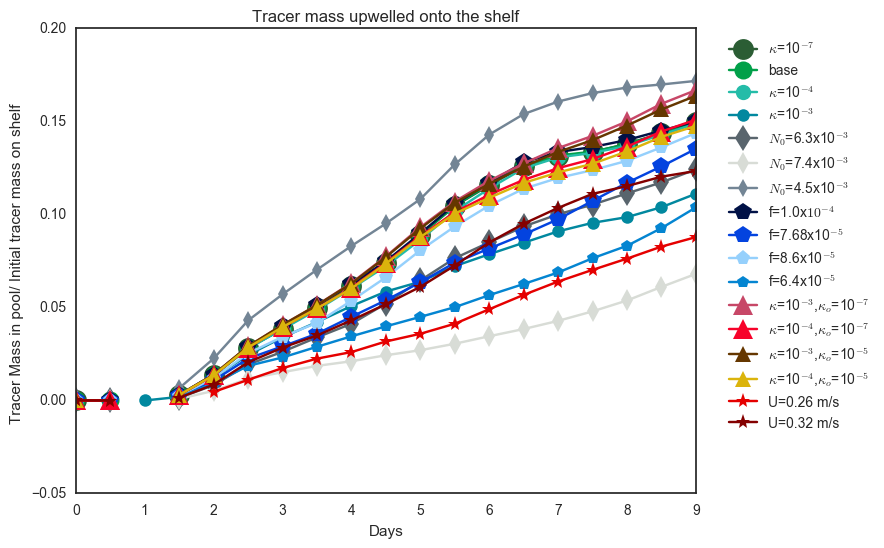

In [11]:
# Choose only the runs that satisfy all restrictions in Allen and Hickey (2010)

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec,recNoC in zip(records,recordsNoC):
    
    plt1 = ax.plot(time[:]/(3600*24),((rec.TrMass)-(recNoC.TrMass))/TotTrMass,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Tracer mass upwelled onto the shelf')
    ax.set_ylabel('Tracer Mass in pool/ Initial tracer mass on shelf ')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.3,1))

plt.show()



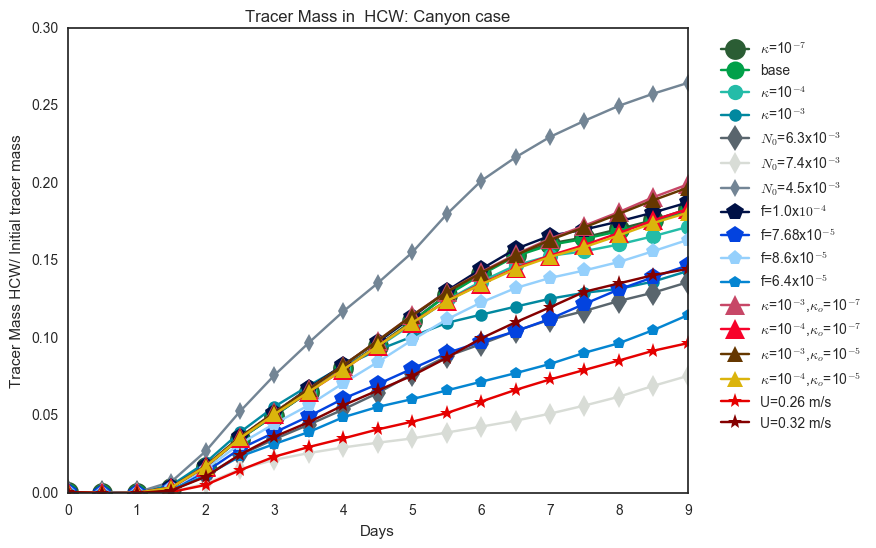

In [12]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records:
    
    plt1 = ax.plot(time[:]/(3600*24),rec.TrMass/TotTrMass,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Tracer Mass in  HCW: Canyon case')
    ax.set_ylabel('Tracer Mass HCW/ Initial tracer mass')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.3,1))

plt.show()



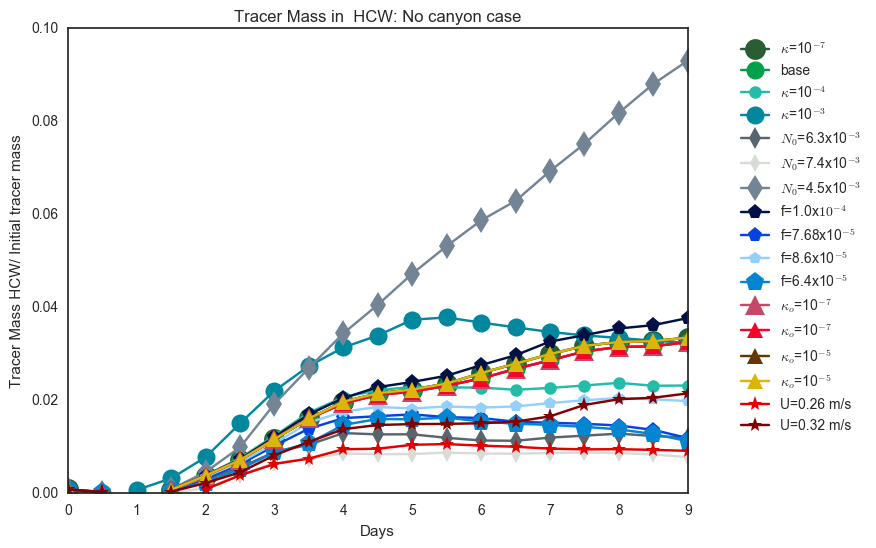

In [13]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for recNoC in recordsNoC:
    
    plt1 = ax.plot(time[:]/(3600*24),recNoC.TrMass/TotTrMass,
                   marker = recNoC.mstyle,
                   markersize = recNoC.msize,
                   color = sns.xkcd_rgb[recNoC.color],
                   label=recNoC.label)
   
    ax.set_title('Tracer Mass in  HCW: No canyon case')
    ax.set_ylabel('Tracer Mass HCW/ Initial tracer mass')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.3,1))

plt.show()



###Tacer mass flux compared to $\bar{C}\Phi_{HA2013}$ 

Upwelling flux from Howatt and Allen (2013) is:

$\frac{\Phi_{AH}}{UWD_h}= 0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.21S_E)^3+0.07$, 

where 

$S_E=\frac{sN}{f(\mathcal{F}_w/R_L)^{1/2}}$

while $\bar C$ is proportional to $(-(Z/H_s)(1-3t/Tau)\delta_zC_0)/2(H_{sb}+H_h)$

where $\delta_zC_0=-0.035983276367187497$

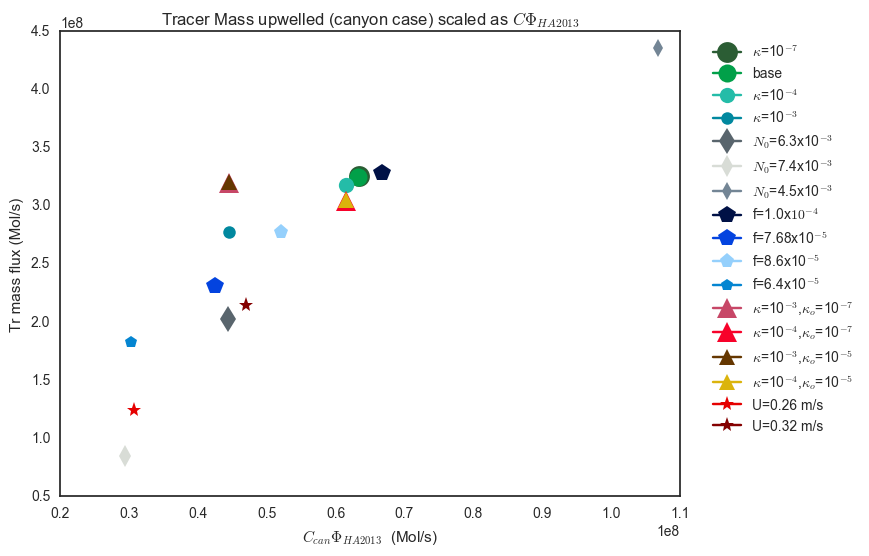

In [14]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
Hh=132.0

for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(3*t*24*3600*rec.kv/((Z**2)))
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    plt1 = ax.plot(1000*HA2013*((-(Z/Hs)*(TauNo))*(Hs+Hh)*-0.03598)/2.0,
                   (((rec.TrMass[8])-(rec.TrMass[6]))/(time[8]-time[6])),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Tracer Mass upwelled (canyon case) scaled as $C \Phi_{HA2013}$')
    ax.set_xlabel('$C_{can} \Phi_{HA2013}$  (Mol/s)')
    ax.set_ylabel('Tr mass flux (Mol/s)')

    ax.legend(bbox_to_anchor=(1.3,1))
    
plt.show()



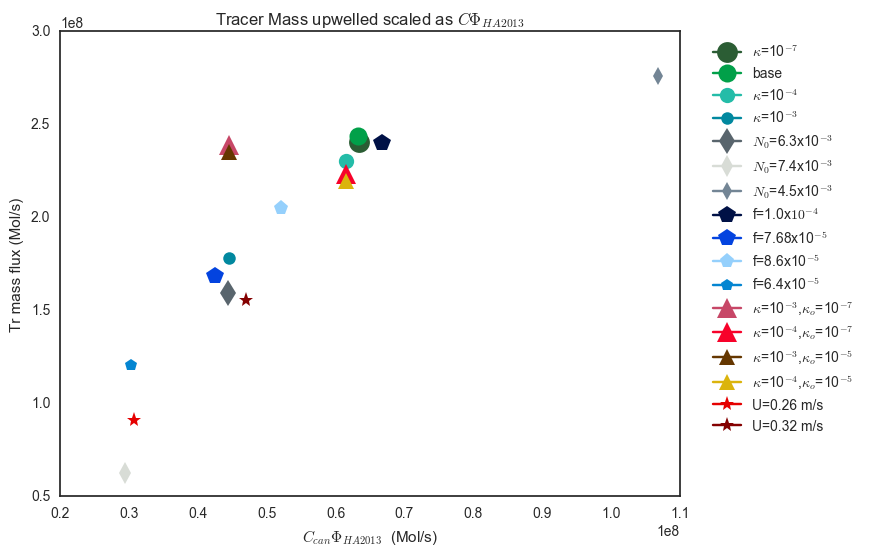

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
Hh=132.0

for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-((3*t*24*3600*rec.kv)/(Z**2))
     
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    plt1 = ax.plot(1000*HA2013*((-(Z/Hs)*(TauNo))*(Hs+Hh)*-0.03598)/2.0,
                   (((rec.TrMass[8]-recNoC.TrMass[8])-(rec.TrMass[6]-recNoC.TrMass[6]))/(time[8]-time[6])),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Tracer Mass upwelled scaled as $C \Phi_{HA2013}$')
    ax.set_xlabel('$C_{can} \Phi_{HA2013}$  (Mol/s)')
    ax.set_ylabel('Tr mass flux (Mol/s)')

    ax.legend(bbox_to_anchor=(1.3,1))
    
plt.show()



### Using corrected stratification (kv) to calculate $\Phi$ 

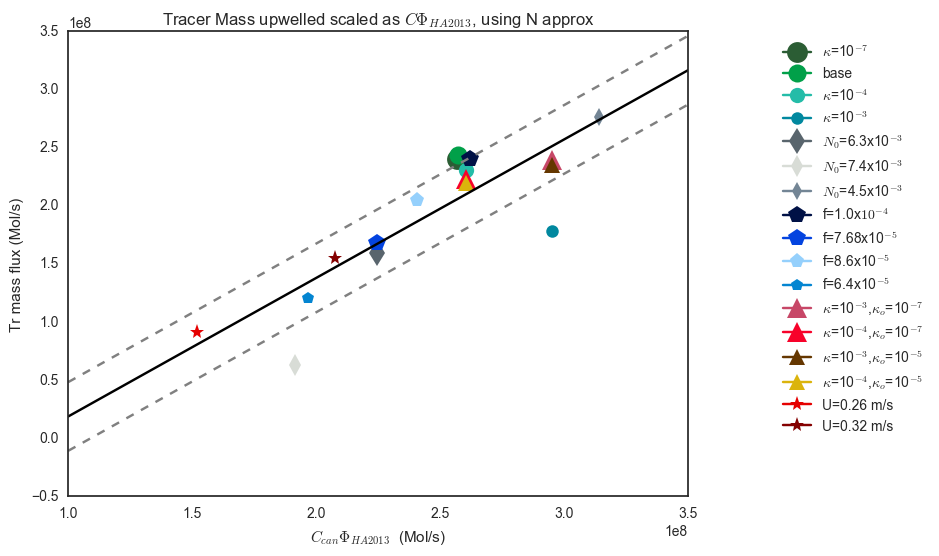

1.19178830101 -100499027.028


In [28]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
Hh=132.0

for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-((4*t*24*3600*rec.kv)/(Z**2))
    
    rec.Z=Z
    rec.TauNo=TauNo
    
    Napprox=((Z/Hs)*(TauNo))*rec.N
    
    Se = (s*Napprox)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,Napprox))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    rec.HA2013=HA2013
    plt1 = ax.plot(1000*HA2013*((-(Z/Hs)*(TauNo))*(Hs+Hh)*-0.03598)/2.0,
                   (((rec.TrMass[8]-recNoC.TrMass[8])-(rec.TrMass[6]-recNoC.TrMass[6]))/(time[8]-time[6])),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Tracer Mass upwelled scaled as $C \Phi_{HA2013}$, using N approx')
    ax.set_xlabel('$C_{can} \Phi_{HA2013}$  (Mol/s)')
    ax.set_ylabel('Tr mass flux (Mol/s)')

    ax.legend(bbox_to_anchor=(1.3,1))
 

#Linear fit

maxN_array_Kv = np.array([(((rec.TrMass[8]-recNoC.TrMass[8])-(rec.TrMass[6]-recNoC.TrMass[6]))/(time[8]-time[6])) 
                          for rec,recNoC in zip(records,recordsNoC)])
tilt_array_Kv = np.array([1000*rec.HA2013*((-(rec.Z/Hs)*(rec.TauNo))*(Hs+Hh)*-0.03598)/2.0 
                          for rec,recNoC in zip(records,recordsNoC)])

x_fit = np.linspace(1E8, 3.5E8, 50)

slope_Kv, intercept_Kv, r_value_Kv, p_value_Kv, std_err_Kv = scipy.stats.linregress(tilt_array_Kv,maxN_array_Kv)

plt3 = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv,'-k')

mean_sq_err_Kv = np.mean((maxN_array_Kv-(slope_Kv*tilt_array_Kv+intercept_Kv))**2)

upper_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv+(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv-(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')
ax.legend(bbox_to_anchor=(1.4,1))


plt.show()

print(slope_Kv,intercept_Kv)


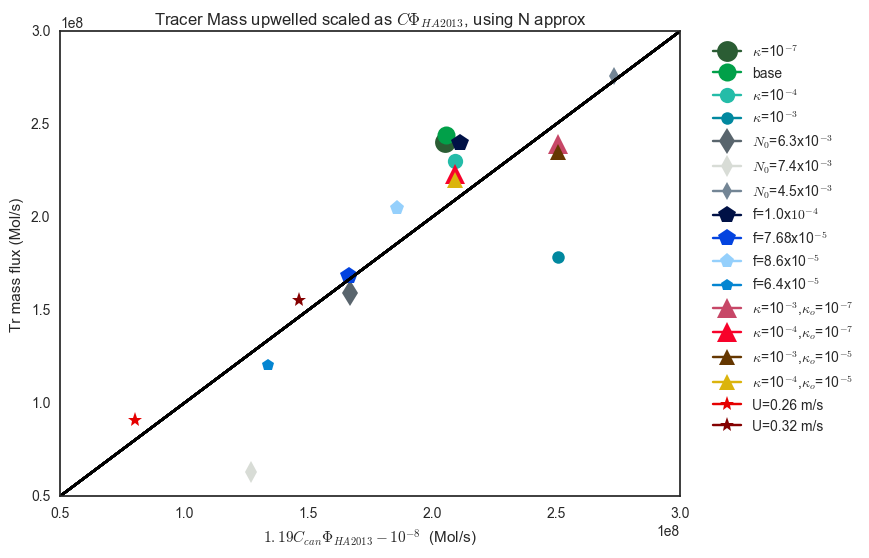

In [31]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
Hh=132.0

for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-((4*t*24*3600*rec.kv)/(Z**2))
    
    rec.Z=Z
    rec.TauNo=TauNo
    
    Napprox=((Z/Hs)*(TauNo))*rec.N
    
    Se = (s*Napprox)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,Napprox))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    rec.HA2013=HA2013
    plt1 = ax.plot((1.19*1000*HA2013*((-(Z/Hs)*(TauNo))*(Hs+Hh)*(-0.03598))/2.0)-100499027.028,
                   (((rec.TrMass[8]-recNoC.TrMass[8])-(rec.TrMass[6]-recNoC.TrMass[6]))/(time[8]-time[6])),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
    ax.plot(np.linspace(0.5E8,3.0E8,50),np.linspace(0.5E8,3.0E8,50),'k-')
    ax.set_title('Tracer Mass upwelled scaled as $C \Phi_{HA2013}$, using N approx')
    ax.set_xlabel('$1.19C_{can} \Phi_{HA2013}-10^{-8}$  (Mol/s)')
    ax.set_ylabel('Tr mass flux (Mol/s)')

    ax.legend(bbox_to_anchor=(1.3,1))


plt.show()



In [21]:
flux_file43 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run43/FluxTR01Glob.nc'
flux_file38 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/FluxTR01Glob.nc'
flux_file37 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run37/FluxTR01Glob.nc'
flux_file36 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/FluxTR01Glob.nc'

flux_fileN63 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run45/FluxTR01Glob.nc'
flux_fileN74 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run73/FluxTR01Glob.nc'
flux_fileN45 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run75/FluxTR01Glob.nc'

flux_filef10 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run67/FluxTR01Glob.nc'
flux_filef76 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run51/FluxTR01Glob.nc'
flux_filef86 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run69/FluxTR01Glob.nc'
flux_filef64 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run71/FluxTR01Glob.nc'

flux_file3D04 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run01/FluxTR01Glob.nc'
flux_file3D05 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run02/FluxTR01Glob.nc'
flux_file3D06 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03/FluxTR01Glob.nc'
flux_file3D07 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run04/FluxTR01Glob.nc'
flux_fileU26 = '/ocean/kramosmu/MITgcm/TracerExperiments/LOW_BF/run01/FluxTR01Glob.nc'
flux_fileU32 = '/ocean/kramosmu/MITgcm/TracerExperiments/LOWER_BF/run01/FluxTR01Glob.nc'


In [22]:
import xarray as xr

In [23]:
grid = xr.open_dataset(CanyonGrid)

FluxFiles =[flux_file43 ,
            flux_file38, 
            flux_file37,
            flux_file36, 
            flux_fileN63, 
            flux_fileN74, 
            flux_fileN45, 
            flux_filef10, 
            flux_filef76, 
            flux_filef86,
            flux_filef64, 
            flux_file3D04, 
            flux_file3D05, 
            flux_file3D06, 
            flux_file3D07 ,
            flux_fileU26,
            flux_fileU32]

for file,rec in  zip(FluxFiles,records):
    dataset = xr.open_dataset(file)
    
    TotTr01 = (dataset.WTRAC01.isel(Zmd000090=29, X= slice(120,240), Y=slice(229,267)))
    rAexp = np.expand_dims(grid.rA.isel(X= slice(120,240), Y=slice(229,267)),0)
    rAexp = np.zeros(np.shape(TotTr01)) + rAexp
    totalV = ((TotTr01 * rAexp).sum(dim='X')).sum(dim='Y')
    rec.TotTrFlux=(totalV).isel(T=slice(6,9)).mean(dim='T')

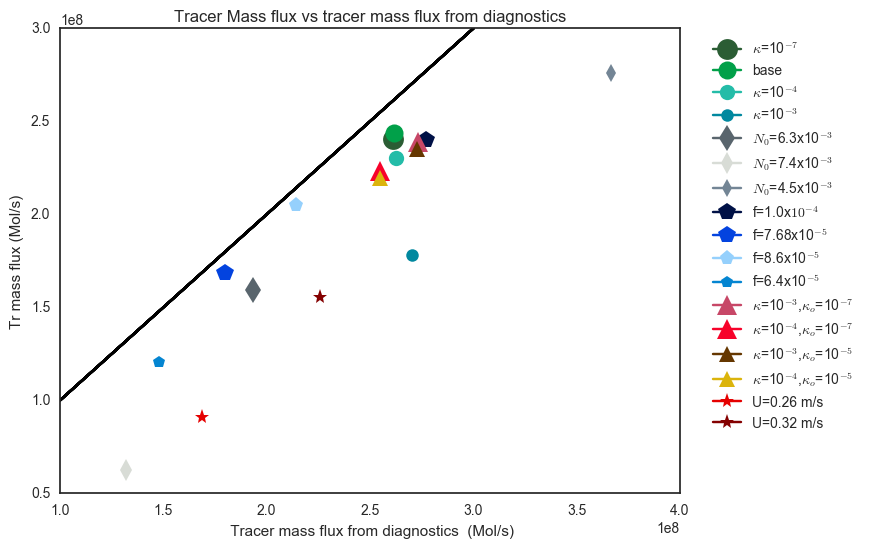

In [24]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
Hh=132.0

for rec,recNoC in zip(records,recordsNoC):
    
    plt1 = ax.plot(rec.TotTrFlux*1000,
                   (((rec.TrMass[8]-recNoC.TrMass[8])-(rec.TrMass[6]-recNoC.TrMass[6]))/(time[8]-time[6])),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
    ax.plot(np.linspace(1E8,3E8,100),np.linspace(1E8,3E8,100),'k-')
    ax.set_title('Tracer Mass flux vs tracer mass flux from diagnostics')
    ax.set_xlabel(' Tracer mass flux from diagnostics  (Mol/s)')
    ax.set_ylabel('Tr mass flux (Mol/s)')

    ax.legend(bbox_to_anchor=(1.3,1))
    
plt.show()

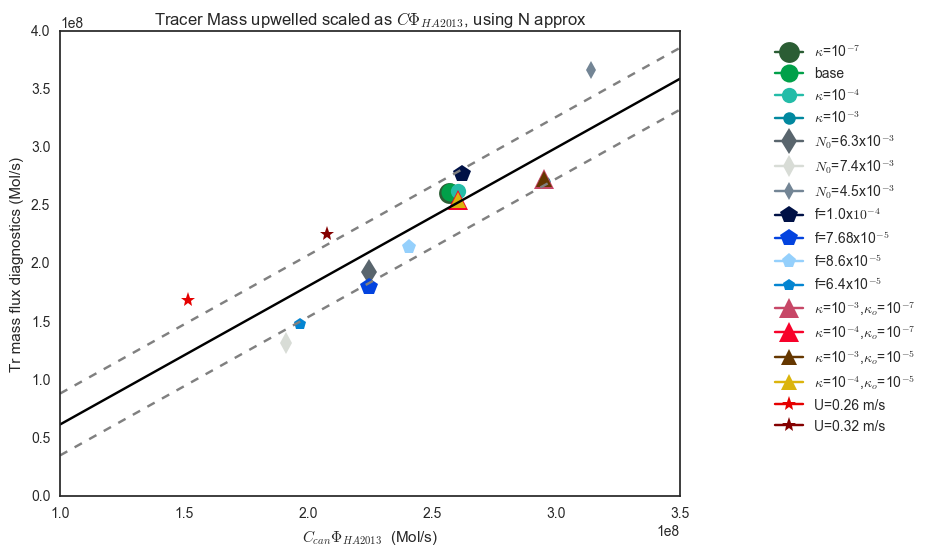

In [27]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]
t=4 # days
Hh=132.0

for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-((4*t*24*3600*rec.kv)/(Z**2))
    
    Napprox=((Z/Hs)*(TauNo))*rec.N
    
    Se = (s*Napprox)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,Napprox))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    rec.HA2013=HA2013
    plt1 = ax.plot(1000*HA2013*((-(Z/Hs)*(TauNo))*(Hs+Hh)*-0.03598)/2.0,
                   (rec.TotTrFlux*1000),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Tracer Mass upwelled scaled as $C \Phi_{HA2013}$, using N approx')
    ax.set_xlabel('$C_{can} \Phi_{HA2013}$  (Mol/s)')
    ax.set_ylabel('Tr mass flux diagnostics (Mol/s)')

    ax.legend(bbox_to_anchor=(1.3,1))
    
#Linear fit

maxN_array_Kv = np.array([rec.TotTrFlux*1000 for rec,recNoC in zip(records,recordsNoC)])
tilt_array_Kv = np.array([1000*rec.HA2013*((-(rec.Z/Hs)*(rec.TauNo))*(Hs+Hh)*-0.03598)/2.0 
                          for rec,recNoC in zip(records,recordsNoC)])

x_fit = np.linspace(1E8, 3.5E8, 50)

slope_Kv, intercept_Kv, r_value_Kv, p_value_Kv, std_err_Kv = scipy.stats.linregress(tilt_array_Kv,maxN_array_Kv)

plt3 = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv,'-k')

mean_sq_err_Kv = np.mean((maxN_array_Kv-(slope_Kv*tilt_array_Kv+intercept_Kv))**2)

upper_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv+(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax.plot(x_fit,slope_Kv*x_fit+intercept_Kv-(mean_sq_err_Kv)**(0.5),linestyle = '--',color='0.5')
ax.legend(bbox_to_anchor=(1.4,1))

plt.show()

